### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from outliertree import OutlierTree


### Load the data

In [3]:
data = pd.read_csv('./data/alzheimers_disease_data.csv')
data.columns = [col.lower() for col in data.columns]


pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientid                  2149 non-null   int64  
 1   age                        2149 non-null   int64  
 2   gender                     2149 non-null   int64  
 3   ethnicity                  2149 non-null   int64  
 4   educationlevel             2149 non-null   int64  
 5   bmi                        2149 non-null   float64
 6   smoking                    2149 non-null   int64  
 7   alcoholconsumption         2149 non-null   float64
 8   physicalactivity           2149 non-null   float64
 9   dietquality                2149 non-null   float64
 10  sleepquality               2149 non-null   float64
 11  familyhistoryalzheimers    2149 non-null   int64  
 12  cardiovasculardisease      2149 non-null   int64  
 13  diabetes                   2149 non-null   int64

### Fix categorical values

In [4]:
bool_cols = ['gender', 'ethnicity', 'educationlevel', 'smoking', 'familyhistoryalzheimers', 'cardiovasculardisease', 'diabetes', 'depression', 'headinjury', 'hypertension', 'memorycomplaints', 'behavioralproblems', 'confusion', 'disorientation', 'personalitychanges', 'difficultycompletingtasks', 'forgetfulness', 'diagnosis']
for col in bool_cols:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   patientid                  2149 non-null   int64   
 1   age                        2149 non-null   int64   
 2   gender                     2149 non-null   category
 3   ethnicity                  2149 non-null   category
 4   educationlevel             2149 non-null   category
 5   bmi                        2149 non-null   float64 
 6   smoking                    2149 non-null   category
 7   alcoholconsumption         2149 non-null   float64 
 8   physicalactivity           2149 non-null   float64 
 9   dietquality                2149 non-null   float64 
 10  sleepquality               2149 non-null   float64 
 11  familyhistoryalzheimers    2149 non-null   category
 12  cardiovasculardisease      2149 non-null   category
 13  diabetes                   2149 n

In [5]:
data.head()

,patientid,age,gender,ethnicity,educationlevel,bmi,smoking,alcoholconsumption,physicalactivity,dietquality,sleepquality,familyhistoryalzheimers,cardiovasculardisease,diabetes,depression,headinjury,hypertension,systolicbp,diastolicbp,cholesteroltotal,cholesterolldl,cholesterolhdl,cholesteroltriglycerides,mmse,functionalassessment,memorycomplaints,behavioralproblems,adl,confusion,disorientation,personalitychanges,difficultycompletingtasks,forgetfulness,diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682564,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407995,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0


### Check outliers

In [6]:
ot = OutlierTree()
out_train = ot.fit(data.select_dtypes(include=[np.number]))
print(out_train)

No outliers found in input data.

OutlierTree model
	Numeric variables: 16

Consists of 16 clusters, spread across 16 tree branches



### Check missing values

In [7]:
missing_values = data.isnull().sum()
print(missing_values)

patientid                    0
age                          0
gender                       0
ethnicity                    0
educationlevel               0
bmi                          0
smoking                      0
alcoholconsumption           0
physicalactivity             0
dietquality                  0
sleepquality                 0
familyhistoryalzheimers      0
cardiovasculardisease        0
diabetes                     0
depression                   0
headinjury                   0
hypertension                 0
systolicbp                   0
diastolicbp                  0
cholesteroltotal             0
cholesterolldl               0
cholesterolhdl               0
cholesteroltriglycerides     0
mmse                         0
functionalassessment         0
memorycomplaints             0
behavioralproblems           0
adl                          0
confusion                    0
disorientation               0
personalitychanges           0
difficultycompletingtasks    0
forgetfu

## Exploratory Data Analysis (EDA)

Let's uncover patterns, spot anomalies, and identify relationships between variables.

### 1. Dataset Overview

In [8]:
# Basic statistics
print("Dataset Shape:", data.shape)
print("\n" + "="*60)
print("SUMMARY STATISTICS - NUMERICAL VARIABLES")
print("="*60)
print(data.describe().round(2))

Dataset Shape: (2149, 34)

SUMMARY STATISTICS - NUMERICAL VARIABLES
       patientid      age      bmi  alcoholconsumption  physicalactivity  \
count    2149.00  2149.00  2149.00             2149.00           2149.00   
mean     5825.00    74.91    27.66               10.04              4.92   
std       620.51     8.99     7.22                5.76              2.86   
min      4751.00    60.00    15.01                0.00              0.00   
25%      5288.00    67.00    21.61                5.14              2.57   
50%      5825.00    75.00    27.82                9.93              4.77   
75%      6362.00    83.00    33.87               15.16              7.43   
max      6899.00    90.00    39.99               19.99              9.99   

       dietquality  sleepquality  systolicbp  diastolicbp  cholesteroltotal  \
count      2149.00       2149.00     2149.00      2149.00           2149.00   
mean          4.99          7.05      134.26        89.85            225.20   
std       

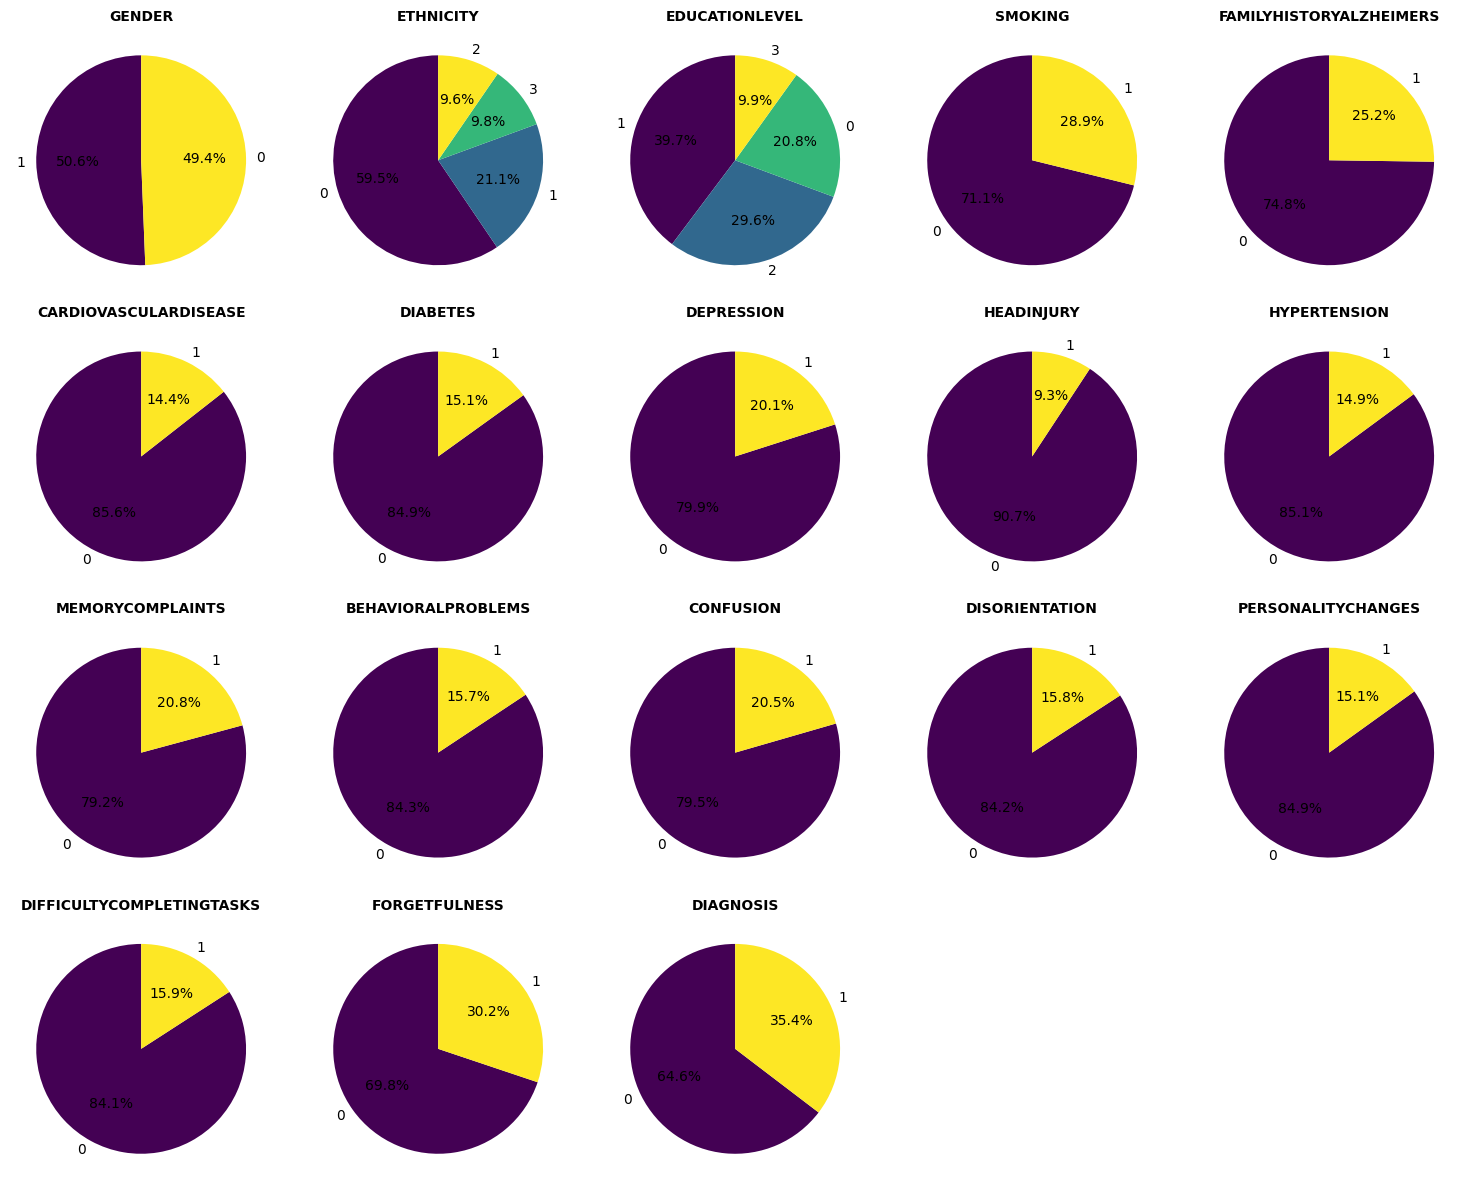

In [ ]:
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
n_cols = 5
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    data[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis', ax=axes[idx])
    axes[idx].set_title(f'{col.upper()}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('')

for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')
    
plt.tight_layout()
plt.show()

### 3. Numerical Variables Distribution & Outliers

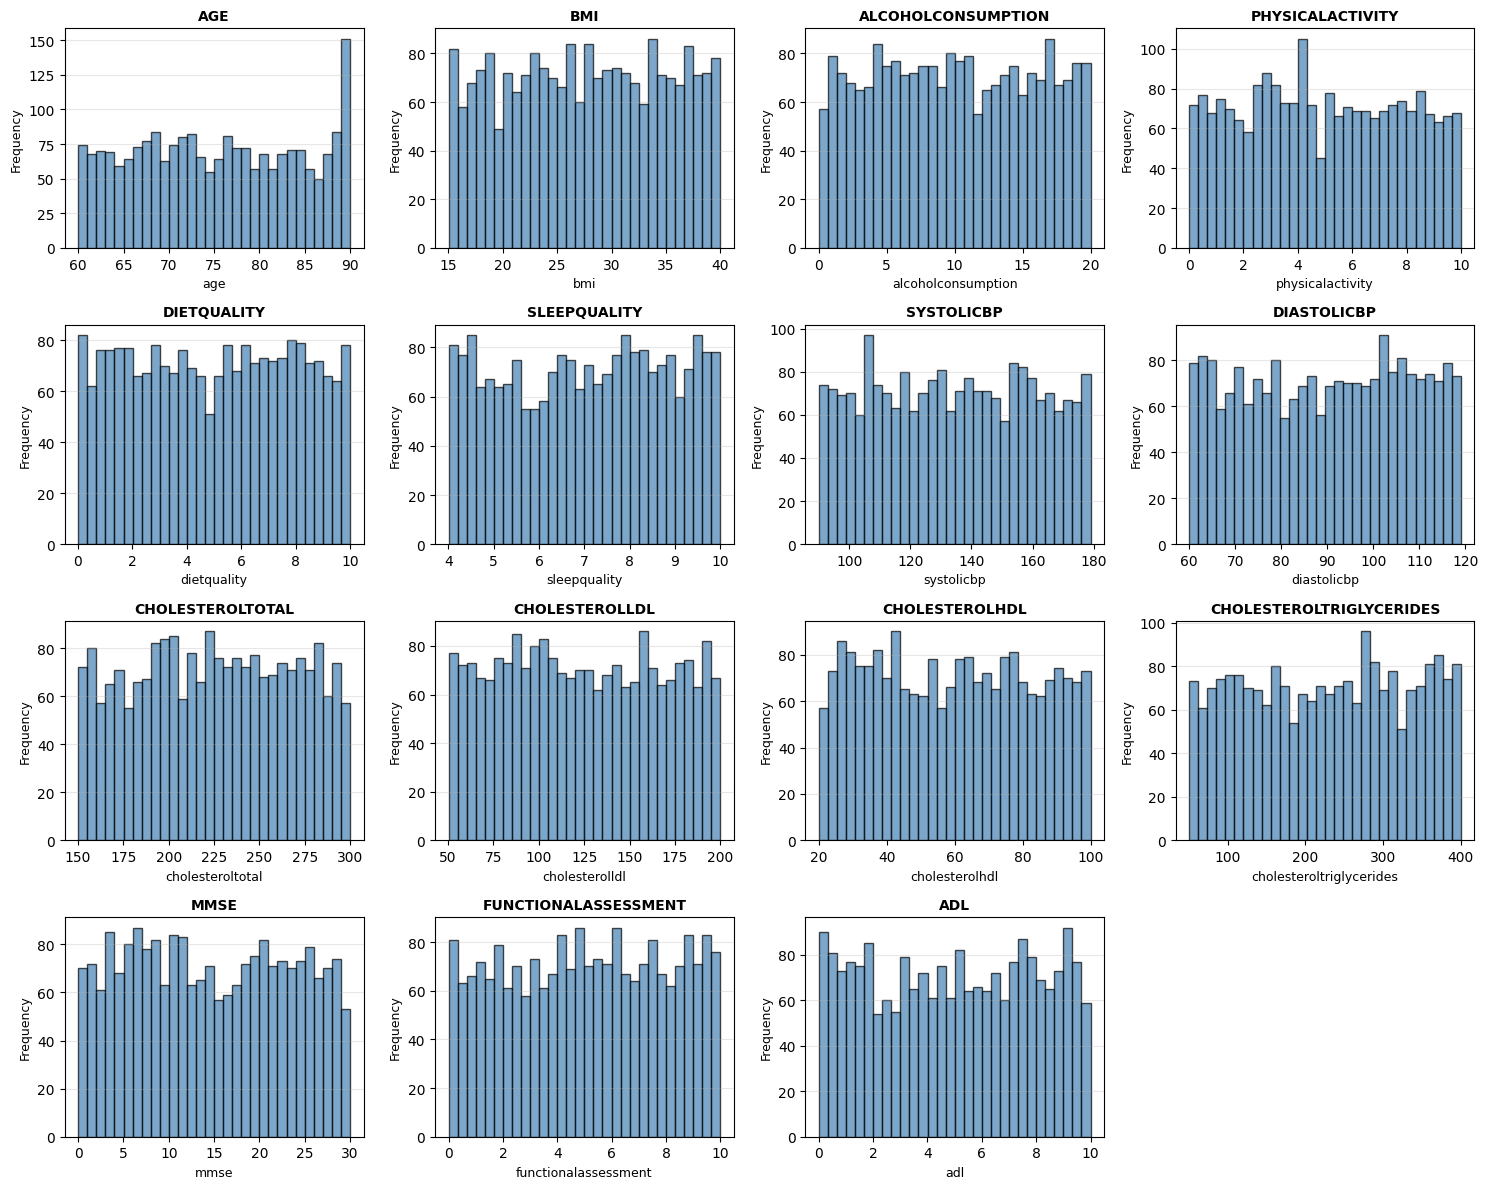

In [22]:
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('patientid') 

n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(data[col].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{col.upper()}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4. Correlation Analysis

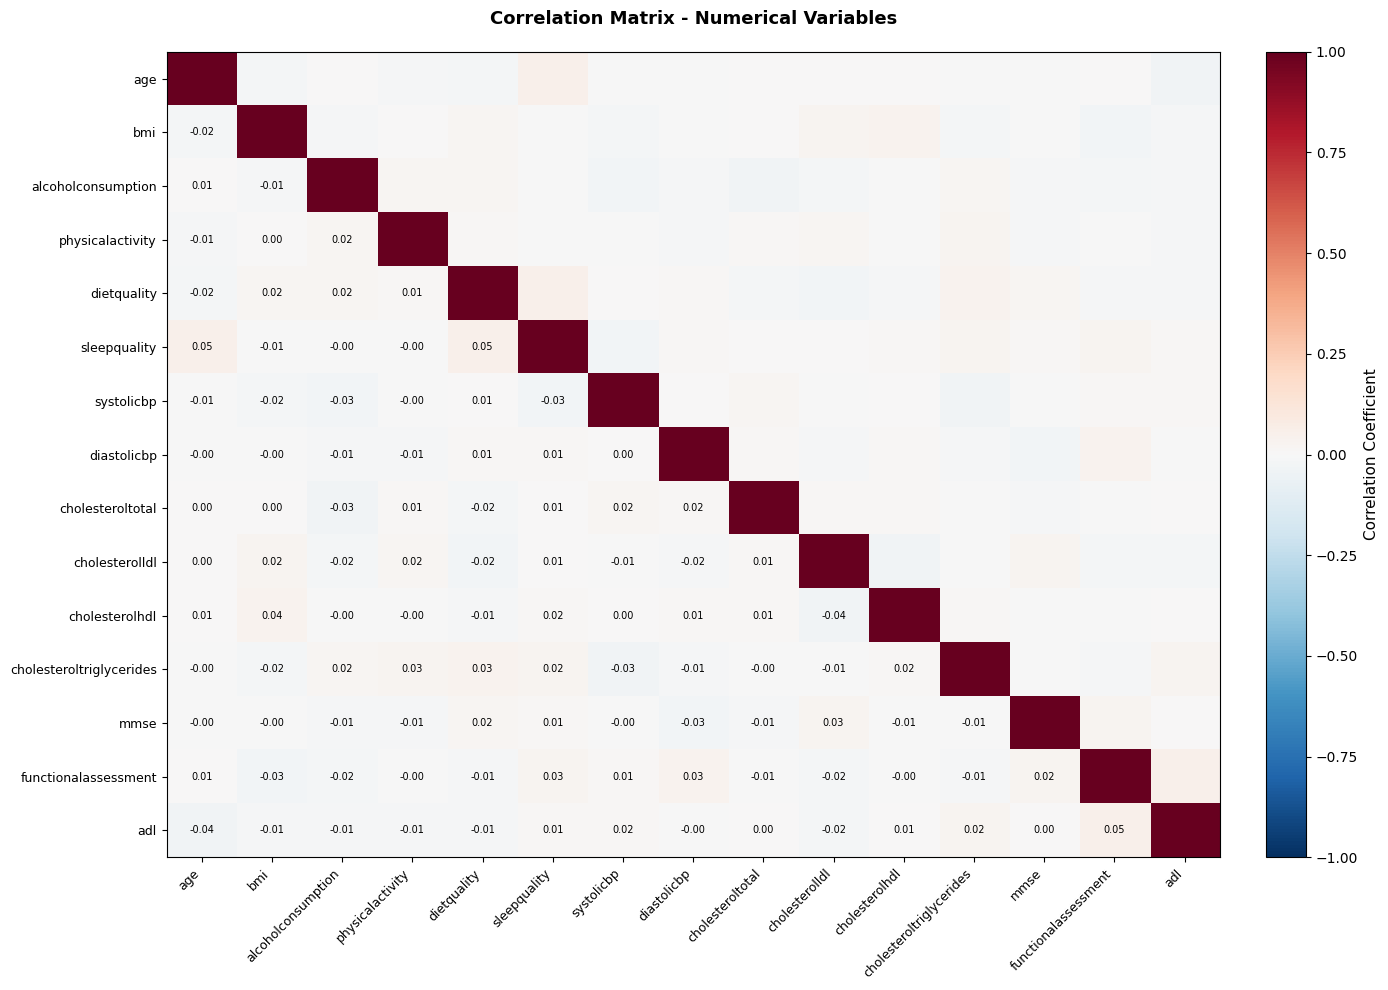

In [23]:
correlation_matrix = data[numerical_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
im = plt.imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=11)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=9)

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if not mask[i, j]:
            text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=7)

plt.title('Correlation Matrix - Numerical Variables', fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
comparison_data = []

for col in numerical_cols:
    no_diag = data[data['diagnosis'] == data['diagnosis'].cat.categories[0]][col]
    yes_diag = data[data['diagnosis'] == data['diagnosis'].cat.categories[1]][col]
    
    comparison_data.append({
        'Variable': col,
        'Mean (No Diagnosis)': round(no_diag.mean(), 2),
        'Mean (Yes Diagnosis)': round(yes_diag.mean(), 2),
        'Difference': round(yes_diag.mean() - no_diag.mean(), 2),
        'Std (No)': round(no_diag.std(), 2),
        'Std (Yes)': round(yes_diag.std(), 2)
    })

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_string(index=False))

                Variable  Mean (No Diagnosis)  Mean (Yes Diagnosis)  Difference  Std (No)  Std (Yes)
                     age                74.95                 74.84       -0.10      8.90       9.15
                     bmi                27.52                 27.91        0.40      7.17       7.30
      alcoholconsumption                10.07                  9.98       -0.09      5.75       5.77
        physicalactivity                 4.91                  4.94        0.04      2.87       2.84
             dietquality                 4.97                  5.03        0.05      2.91       2.91
            sleepquality                 7.12                  6.92       -0.21      1.76       1.76
              systolicbp               134.56                133.72       -0.85     25.95      25.96
             diastolicbp                89.78                 89.97        0.19     17.67      17.46
        cholesteroltotal               225.00                225.57        0.57     42.20  

### 7. Key Patterns & Insights Summary